In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
ddir = Path("/home/edwin/Datasets/biwi_head_pose")

In [8]:
path = Path("/home/edwin/Datasets/biwi_head_pose")

In [5]:
?? np.genfromtxt

In [6]:
cal = np.genfromtxt(ddir/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [9]:
fname = path/'09'/'frame_00667_rgb.jpg'

In [10]:
def img2txt_name(f): return f'{str(f)[:-7]}pose.txt'

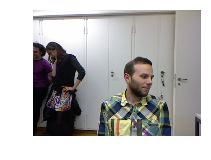

In [12]:
img = open_image(fname)
img.show()

In [13]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [14]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

In [15]:
def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img, pts): return ImagePoints(FlowField(img.size, pts), scale=True)

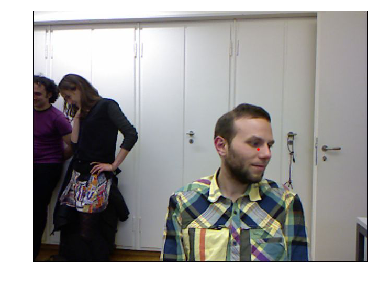

In [16]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6,6))

In [17]:
data = (ImageFileList.from_folder(path)
        .label_from_func(get_ctr)
        .split_by_valid_func(lambda o: o[0].parent.name == '13')
        .datasets(PointsDataset)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats))

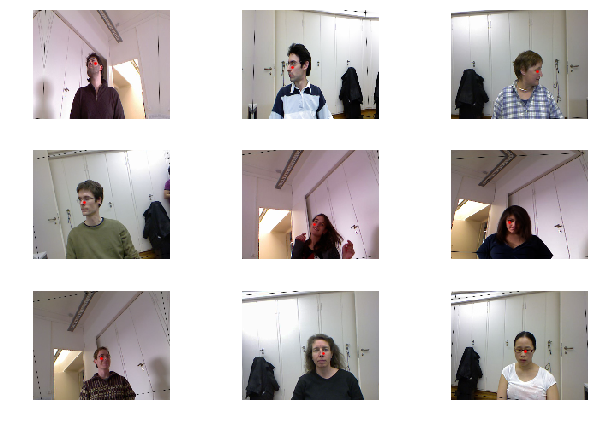

In [18]:
data.show_batch(3, figsize=(9,6))

In [19]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


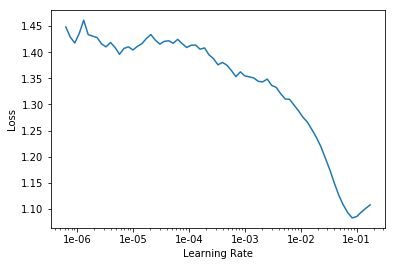

In [20]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 2e-2

In [23]:
learn.fit_one_cycle(5, slice(lr))

Total time: 05:36
epoch  train_loss  valid_loss
1      0.039133    0.002223    (01:07)
2      0.015210    0.007651    (01:06)
3      0.005258    0.001507    (01:06)
4      0.003150    0.000949    (01:07)
5      0.002054    0.002170    (01:08)



In [24]:
learn.save('stage-1-biwi.pth')

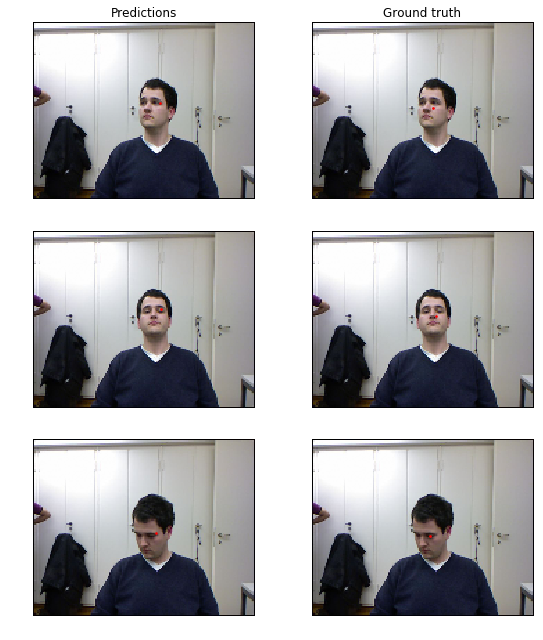

In [25]:
learn.show_results()